In [1]:
import glob
import pandas as pd
import json
import datetime
from tqdm import tqdm
import os
from django.conf import settings
#from sqlalchemy import create_engine
os.environ["DJANGO_SETTINGS_MODULE"] = "mysite.settings"
import django
django.setup()
from tqdm import tqdm, tqdm_notebook
import glob
import numpy as np

from django.db.models import Min,Max,Count
from sklearn.neighbors import KDTree
comfig_file_path = '../../main_config.txt'
main_name = 'yandex/'
sub_name = 'raw_org_search/'
import time
from sklearn.utils import shuffle
from django.db.models import Q

/home/tserekh/env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/home/tserekh/env/lib/python3.6/site-packages/django/db/models/base.py:299: RuntimeWarning: Model 'main_map.predictedsquare' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)


In [2]:
import sys
import json
sys.path.append('/usr/lib/python3/dist-packages')
from main_map.models import OrganizationNatClass, House, Metro, Distance, City

In [3]:
nat_classes = ['Супермаркет']
lat_min, lon_min = 55.604865, 37.321688
lat_max, lon_max = 55.912290, 37.858644

lat_min, lon_min = 55.667588, 37.432773
lat_max, lon_max = 55.854200, 37.777469




filter_geo =    {
    'lat__gt' : lat_min, 
    'lon__gt' : lon_min,
    'lat__lt' : lat_max, 
    'lon__lt' : lon_max,
}


In [6]:
def brand_map(lat_min, lon_min, lat_max, lon_max, nat_classes, distance_name):
    xy = ['x','y']
    unq = ['source_id1','source_id2','source_name1','source_name2']

    columns = ['source_id','source_name','nat_class','chain_name']#nat_class just for fi
    filter_dic = filter_geo.copy()
    filter_dic['nat_class__in'] = nat_classes
    df_orgs = pd.DataFrame(list(OrganizationNatClass.objects.filter(**filter_dic).values().values_list(*columns)),
                           columns=columns)
    print('orgs done')
    orgs_ids = df_orgs['source_id'].values
    df_orgs = df_orgs.set_index(['source_id', 'source_name'])

    columns = ['source_id','source_name','flat_num','x','y']

    df_homes = pd.DataFrame(list(House.objects.filter(**filter_geo).values().values_list(*columns)),columns=columns)
    print('homes done')
    home_ids = df_homes['source_id'].values
    df_homes = df_homes.set_index(['source_id', 'source_name'])

    q1 = Distance.objects.filter(
        source_id1__in=orgs_ids,
        source_name1='yandex_api',

        source_id2__in=home_ids,
        source_name2='reformagkh',
    )

    q2 = q1.values(*['source_id2','source_name2']).annotate(**{distance_name : Min(distance_name)})
    df2 = pd.DataFrame(list(q2))
    print('q2 done')
    df1 = pd.DataFrame(list(q1.values(
        *['source_id2', 'source_name2', distance_name, 'source_id1', 'source_name1'])))

    df1 = df1.set_index([distance_name,'source_id2','source_name2'])
    print('q1 done')
    q_orgs = OrganizationNatClass.objects.filter(source_id__in=orgs_ids,
        source_name='yandex_api').values()

    dics = []
    #print(df_homes.head())
    for i, row in tqdm_notebook(df2.iterrows()):
        el = row.to_dict()
        ind_values = [el['source_id2'],el['source_name2'],el[distance_name]]
        dic_dist = df1.loc[ind_values].iloc[0].to_dict()
        
        dic_home = df_homes.loc[[el['source_id2'],el['source_name2']]].iloc[0].to_dict()
        dic_org = df_orgs.loc[[dic_dist['source_id1'],dic_dist['source_name1']]].iloc[0].to_dict()
        dics.append({**el, **dic_dist, **dic_home, **dic_org})
        #print(dic_dist, dic_home, dic_org)
    df = pd.DataFrame(dics)
    
    agg = {}
    agg['chain_name'] = lambda x: list(x)[0] if len(x)!=0 else '-'
    agg['x'] = lambda x: list(x)[0] if len(x)!=0 else '-'
    agg['y'] = lambda x: list(x)[0] if len(x)!=0 else '-'
    agg['flat_num'] = sum
    
    df_orgs = df.groupby(['source_name1','source_id1'],as_index=False).agg(agg)
    return df, df_orgs

In [7]:
distance_name = 'euclid_distance'
#distance_name = 'euclid_distance_metro'

df, df_orgs = brand_map(lat_min, lon_min, lat_max, lon_max, nat_classes, distance_name)

In [9]:
unq = ['source_id1','source_id2','source_name1','source_name2']

In [10]:
from pyproj import Proj, transform
PROJ3857  = Proj("+init=EPSG:3857")
PROJ4326 = Proj("+init=EPSG:4326")


In [11]:
df_orgs = df_orgs.sort_values('flat_num', ascending=False)

In [12]:
row = df_orgs.iloc[0]
print(row)
lon, lat = transform(PROJ3857, PROJ4326, row['x'], row['y'])

source_name1     yandex_api
source_id1       1807783225
chain_name            Густо
x               4.16901e+06
y               7.52028e+06
flat_num               7534
Name: 950, dtype: object


In [13]:
import matplotlib.pyplot as plt

In [18]:
gb = df_orgs.groupby('chain_name')['flat_num'].size()

In [25]:
gb = df_orgs[df_orgs['chain_name'].isin(gb[gb>=5].index)].groupby('chain_name')['flat_num'].mean()

In [26]:
gb.sort_values()

chain_name
Атак                      444.875000
Гастроном                 498.600000
ХЦ                        530.538462
Супермаркет Мираторг      681.500000
Микромаркет               706.625000
EUROSPAR                  707.400000
Продукты 24               739.500000
АВ Daily                  749.121212
Алые Паруса               798.000000
 Углече Поле              799.200000
Мясная лавка Мираторг     825.714286
Азбука Вкуса              835.561404
Продуктовый магазин       854.230769
Перекресток               859.059524
Супермаркет               892.133333
Мой Ашан                  921.750000
Магазин Продукты          953.538462
Фасоль                    997.333333
Billa                    1044.756757
Лента                    1059.142857
Продукты                 1062.609756
Виктория                 1064.916667
Дикси                    1081.585492
Пятёрочка                1116.288630
Минимаркет               1159.000000
Универсам Магнит         1168.764045
Ярче!                    12

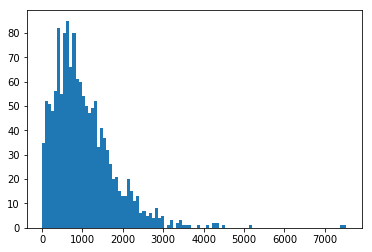

In [16]:
plt.hist(df_orgs['flat_num'].values, bins=100)
plt.show()